In [1]:
import os
import gensim


path = os.path.join('word2vec',
        'GoogleNews-vectors-negative300.bin')
model = gensim.models.KeyedVectors.load_word2vec_format(
        path,
        binary=True
    )

In [2]:
import math
import numpy
from operator import itemgetter
from numpy.linalg import norm

EPSILON = 1e-6

def euclidean(vec1, vec2):
  diff = vec1 - vec2
  return math.sqrt(diff.dot(diff))

def cosine_sim(vec1, vec2):
  vec1 += EPSILON * numpy.ones(len(vec1))
  vec2 += EPSILON * numpy.ones(len(vec1))
  return vec1.dot(vec2)/(norm(vec1)*norm(vec2))

def assign_ranks(item_dict):
  ranked_dict = {}
  sorted_list = [(key, val) for (key, val) in sorted(item_dict.items(),
                                                     key=itemgetter(1),
                                                     reverse=True)]
  for i, (key, val) in enumerate(sorted_list):
    same_val_indices = []
    for j, (key2, val2) in enumerate(sorted_list):
      if val2 == val:
        same_val_indices.append(j+1)
    if len(same_val_indices) == 1:
      ranked_dict[key] = i+1
    else:
      ranked_dict[key] = 1.*sum(same_val_indices)/len(same_val_indices)
  return ranked_dict

def correlation(dict1, dict2):
  avg1 = 1.*sum([val for key, val in dict1.iteritems()])/len(dict1)
  avg2 = 1.*sum([val for key, val in dict2.iteritems()])/len(dict2)
  numr, den1, den2 = (0., 0., 0.)
  for val1, val2 in zip(dict1.itervalues(), dict2.itervalues()):
    numr += (val1 - avg1) * (val2 - avg2)
    den1 += (val1 - avg1) ** 2
    den2 += (val2 - avg2) ** 2
  return numr / math.sqrt(den1 * den2)

def spearmans_rho(ranked_dict1, ranked_dict2):
  assert len(ranked_dict1) == len(ranked_dict2)
  if len(ranked_dict1) == 0 or len(ranked_dict2) == 0:
    return 0.
  x_avg = 1.*sum([val for val in ranked_dict1.values()])/len(ranked_dict1)
  y_avg = 1.*sum([val for val in ranked_dict2.values()])/len(ranked_dict2)
  num, d_x, d_y = (0., 0., 0.)
  for key in ranked_dict1.keys():
    xi = ranked_dict1[key]
    yi = ranked_dict2[key]
    num += (xi-x_avg)*(yi-y_avg)
    d_x += (xi-x_avg)**2
    d_y += (yi-y_avg)**2
  return num/(math.sqrt(d_x*d_y))

In [3]:
vec1=model['test'].tolist()
vec2 =model['exam'].tolist()
cosine_sim(vec1,vec2)

0.5065850456386709

In [4]:
data = model.vectors
print(data.shape)

(3000000, 300)


In [5]:
import numpy as np
num_points = 500000
selected_index = np.random.choice(data.shape[0],size=num_points, replace=True)
train_data = data[selected_index,:]
words = np.array(model.index2word)[selected_index]

In [6]:
def run_word_sim(model,u,results):
    print ('======================================================================================')
    print ("%15s" % "Num Pairs", "%10s" % "Not found", "%15s" % "Word2Vec Rho",  "%15s" % "UMAPed Rho", "word2vec/umap","File name")
    print ('======================================================================================')
 
    word_sim_dir="data/word-sim"

    for i, filename in enumerate(os.listdir(word_sim_dir)):
        not_found, total_size = (0, 0)
        manual_dict, auto_dict,reduced_dict = ({}, {},{})

        for line in open(word_sim_dir+"/"+filename,'r'):
            line = line.strip().lower()
            word1, word2, val = line.split()
            try:
                vec1= model[word1].tolist()
                vec2 = model[word2].tolist()

                u_vec1 = u.transform([vec1] )[0]
                u_vec2 =  u.transform([vec2] )[0]

            except Exception as e:
                not_found+=1
                next 
            manual_dict[(word1, word2)] = float(val)
            auto_dict[(word1, word2)] = cosine_sim(vec1, vec2)
            reduced_dict[(word1, word2)] = cosine_sim(u_vec1, u_vec2)
            total_size += 1    
        
        results[filename].append(spearmans_rho(assign_ranks(manual_dict), assign_ranks(reduced_dict)))
        
        
        print ( "%15s" % str(total_size), "%10s" % str(not_found), "%15.4f" % spearmans_rho(assign_ranks(manual_dict), assign_ranks(auto_dict)),
               "%15.4f" % spearmans_rho(assign_ranks(manual_dict), assign_ranks(reduced_dict)),"%15.4f" % spearmans_rho(assign_ranks(auto_dict), assign_ranks(reduced_dict)),
              filename)


In [7]:
import umap
from collections import defaultdict

dataset_results = defaultdict(list)

fit10 = umap.UMAP(n_neighbors=15, random_state=42,n_components=10, metric='cosine')
%time u10 = fit10.fit(train_data)
run_word_sim (model,u10,dataset_results)

fit30 = umap.UMAP(n_neighbors=15, random_state=42,n_components=30, metric='cosine')
%time u30 = fit30.fit(train_data)
run_word_sim (model,u30,dataset_results)
fit50 = umap.UMAP(n_neighbors=15, random_state=42,n_components=50, metric='cosine')
%time u50 = fit50.fit(train_data)
run_word_sim (model,u50,dataset_results)

fit100 = umap.UMAP(n_neighbors=15, random_state=42,n_components=100, metric='cosine')
%time u100 = fit100.fit(train_data)
run_word_sim (model,u100,dataset_results)

fit150 = umap.UMAP(n_neighbors=15, random_state=42,n_components=150, metric='cosine')
%time u150 = fit150.fit(train_data)
run_word_sim (model,u150,dataset_results)




/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/pyth

CPU times: user 39min 31s, sys: 1min 10s, total: 40min 42s
Wall time: 24min 40s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.1032          0.4099 EN-YP-130.txt
             65          0          0.7498          0.2300          0.3098 EN-RG-65.txt
            287         12          0.6453          0.3518          0.4521 EN-MTurk-287.txt
            999          0          0.4420          0.1710          0.5142 EN-SIMLEX-999.txt
            144          9          0.4929          0.0391          0.3409 EN-VERB-143.txt
            252          2          0.6241          0.3054          0.3857 EN-WS-353-REL.txt
           2034        209          0.4747          0.1697          0.4443 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4673          0.6618 EN-MEN-TR-3k.txt
            353          3          0.6858          0.3405          0.4997 EN-WS-353-ALL.txt
             30          0          0.7880          0.1834          0.2432 EN-MC-30.txt
            771          0          0.6713          0.2086          0.3909 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 44min 26s, sys: 1min, total: 45min 27s
Wall time: 29min 14s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.1157          0.4146 EN-YP-130.txt
             65          0          0.7498          0.2549          0.3281 EN-RG-65.txt
            287         12          0.6453          0.3731          0.4781 EN-MTurk-287.txt
            999          0          0.4420          0.1796          0.5161 EN-SIMLEX-999.txt
            144          9          0.4929          0.0472          0.3534 EN-VERB-143.txt
            252          2          0.6241          0.3216          0.3925 EN-WS-353-REL.txt
           2034        209          0.4747          0.1713          0.4509 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4816          0.6704 EN-MEN-TR-3k.txt
            353          3          0.6858          0.3510          0.5139 EN-WS-353-ALL.txt
             30          0          0.7880          0.2288          0.2854 EN-MC-30.txt
            771          0          0.6713          0.2212          0.4053 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 1h 6min 57s, sys: 2min 48s, total: 1h 9min 45s
Wall time: 37min 37s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.1098          0.4101 EN-YP-130.txt
             65          0          0.7498          0.2501          0.3273 EN-RG-65.txt
            287         12          0.6453          0.3711          0.4713 EN-MTurk-287.txt
            999          0          0.4420          0.1723          0.5376 EN-SIMLEX-999.txt
            144          9          0.4929          0.0666          0.3269 EN-VERB-143.txt
            252          2          0.6241          0.3120          0.3856 EN-WS-353-REL.txt
           2034        209          0.4747          0.1717          0.4491 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4861          0.6735 EN-MEN-TR-3k.txt
            353          3          0.6858          0.3459          0.5064 EN-WS-353-ALL.txt
             30          0          0.7880          0.2225          0.2792 EN-MC-30.txt
            771          0          0.6713          0.2237          0.4111 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 1h 33min 6s, sys: 3min, total: 1h 36min 7s
Wall time: 48min 57s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.1129          0.4111 EN-YP-130.txt
             65          0          0.7498          0.2553          0.3300 EN-RG-65.txt
            287         12          0.6453          0.3715          0.4777 EN-MTurk-287.txt
            999          0          0.4420          0.1772          0.5435 EN-SIMLEX-999.txt
            144          9          0.4929          0.0448          0.3578 EN-VERB-143.txt
            252          2          0.6241          0.3143          0.3851 EN-WS-353-REL.txt
           2034        209          0.4747          0.1729          0.4499 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4858          0.6734 EN-MEN-TR-3k.txt
            353          3          0.6858          0.3474          0.5108 EN-WS-353-ALL.txt
             30          0          0.7880          0.2337          0.2814 EN-MC-30.txt
            771          0          0.6713          0.2224          0.4137 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 2h 2min 42s, sys: 3min 58s, total: 2h 6min 41s
Wall time: 1h 1min 5s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.1119          0.4122 EN-YP-130.txt
             65          0          0.7498          0.2519          0.3288 EN-RG-65.txt
            287         12          0.6453          0.3726          0.4773 EN-MTurk-287.txt
            999          0          0.4420          0.1728          0.5374 EN-SIMLEX-999.txt
            144          9          0.4929          0.0342          0.3708 EN-VERB-143.txt
            252          2          0.6241          0.3136          0.3849 EN-WS-353-REL.txt
           2034        209          0.4747          0.1705          0.4473 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4870          0.6749 EN-MEN-TR-3k.txt
            353          3          0.6858          0.3479          0.5118 EN-WS-353-ALL.txt
             30          0          0.7880          0.2399          0.2877 EN-MC-30.txt
            771          0          0.6713          0.2225          0.4106 EN-MTurk-771

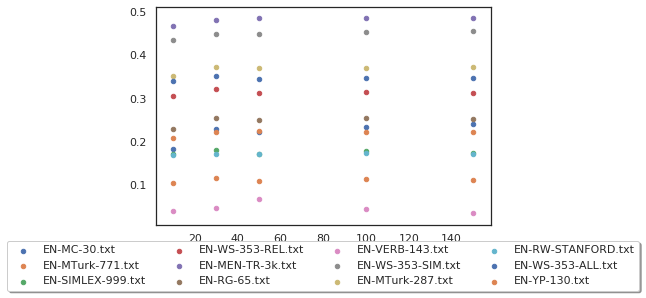

In [8]:
 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(6,4)})
 
x=[10,30,50,100,150]

files =[ 'EN-MC-30.txt','EN-MTurk-771.txt','EN-SIMLEX-999.txt','EN-WS-353-REL.txt',
'EN-MEN-TR-3k.txt','EN-RG-65.txt','EN-VERB-143.txt','EN-WS-353-SIM.txt',
'EN-MTurk-287.txt','EN-RW-STANFORD.txt','EN-WS-353-ALL.txt','EN-YP-130.txt']

for f in files:
    plt.scatter(x,dataset_results[f],s=20,label=f)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)

plt.show()

